In [16]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from numba import jit
import numpy as np 
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=""
import tensorflow as tf
from matplotlib import pyplot
import sys
import keras
import cv2
import pandas as pd
import re
from src import CLLayers, CLUtils, CLLosses
from trainLineCounterV2 import parse_model_name, spell_model_name, create_model_v2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
#Create LineCounter and Load Trained Weights

In [18]:
expt_dir = './expts/Allx768xDnCNN/models/'
expt_runs = os.listdir(expt_dir)

In [19]:
summary = {}
for model_name in expt_runs :
    print(model_name)
    if model_name != ".ipynb_checkpoints":
        model_dir = os.path.join(expt_dir, model_name)
        params = parse_model_name(model_name)
        weight_files = [os.path.join(model_dir, wf) for wf in os.listdir(model_dir)]
        scores = [float(w.split('-')[-1].split('.h5')[0]) for w in weight_files]
        best_idx = np.argmax(scores)
        params['val_acc'] = scores[best_idx]
        params['best_weight'] = weight_files[best_idx]
        summary[model_name] = params

BF32:BLK5:BN0,0:M8:LArelu:LCbefore_decoder:SC0:DSdrop:USbilinear:BD1:N0.00:P1


In [20]:
df = pd.DataFrame.from_dict(summary, orient='index')
df = df.sort_values('val_acc', ascending=False)

In [21]:
model_name = str(model_name)
params = parse_model_name(model_name)
model = create_model_v2(**params)
print(model.summary(line_length=120))

________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
doc_in (InputLayer)                    (None, None, None, 1)      0                                                     
________________________________________________________________________________________________________________________
encoder_1a_spad (SymmetricPadding)     (None, None, None, 1)      0             doc_in[0][0]                            
________________________________________________________________________________________________________________________
encoder_1a_conv (Conv2D)               (None, None, None, 32)     320           encoder_1a_spad[0][0]                   
________________________________________________________________________________________________________________________
encoder_1a_bnorm (BatchNormaliza

In [22]:
best_weight_file = summary[model_name]['best_weight']
print(best_weight_file)
model.load_weights(best_weight_file)

./expts/Allx768xDnCNN/models/BF32:BLK5:BN0,0:M8:LArelu:LCbefore_decoder:SC0:DSdrop:USbilinear:BD1:N0.00:P1/BF32:BLK5:BN0,0:M8:LArelu:LCbefore_decoder:SC0:DSdrop:USbilinear:BD1:N0.00:P1-0.9830.h5


In [23]:
#Create ColorMap

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
jet = cm.get_cmap('tab20')
newcolors = jet(np.linspace(0, 1, 256))
white = np.array([0, 0, 0, 1])
newcolors[:13, :] = white
newcmp1 = ListedColormap(newcolors)

1/1 [==============================] - 1s 1s/step


/home/viplab/.local/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1/1 [==============================] - 1s 1s/step


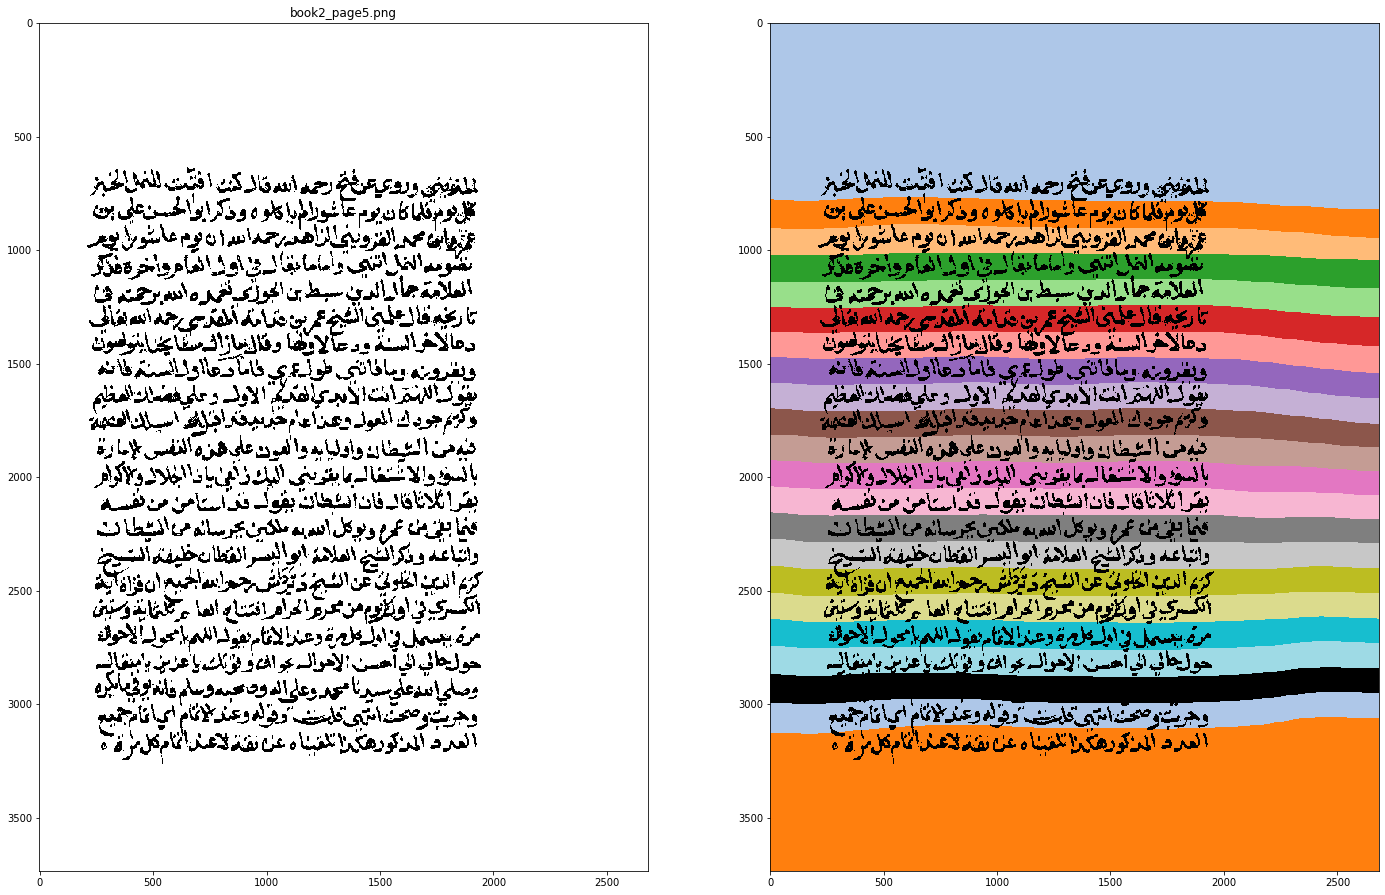

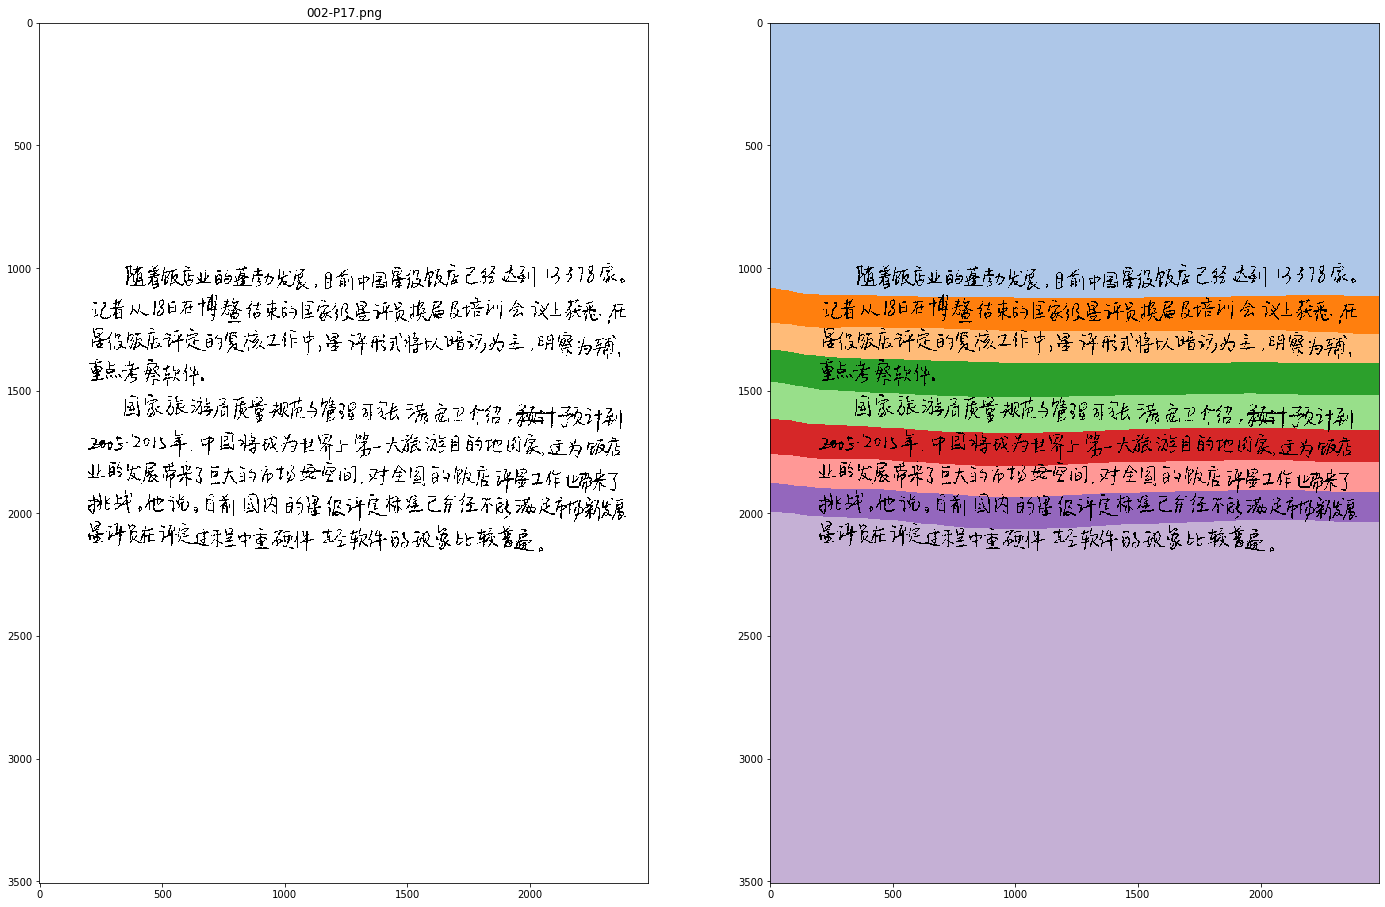

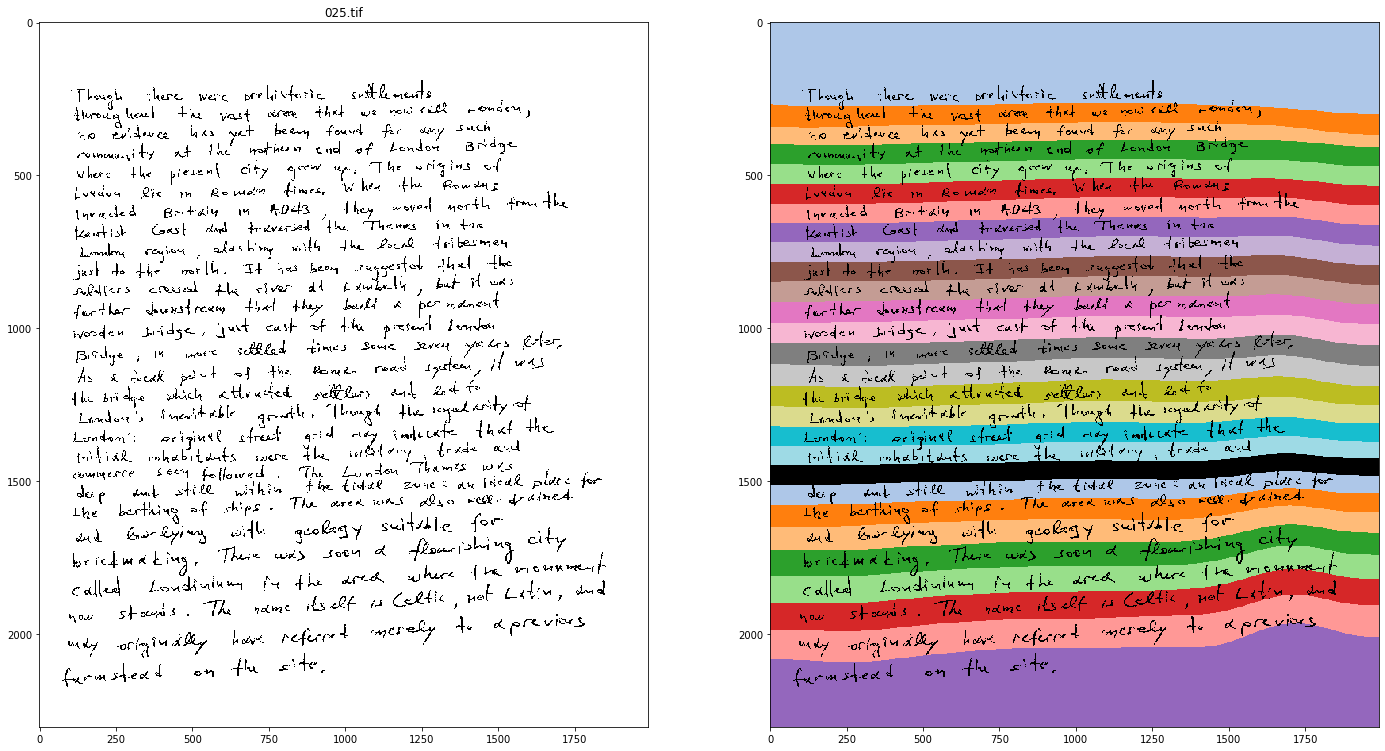

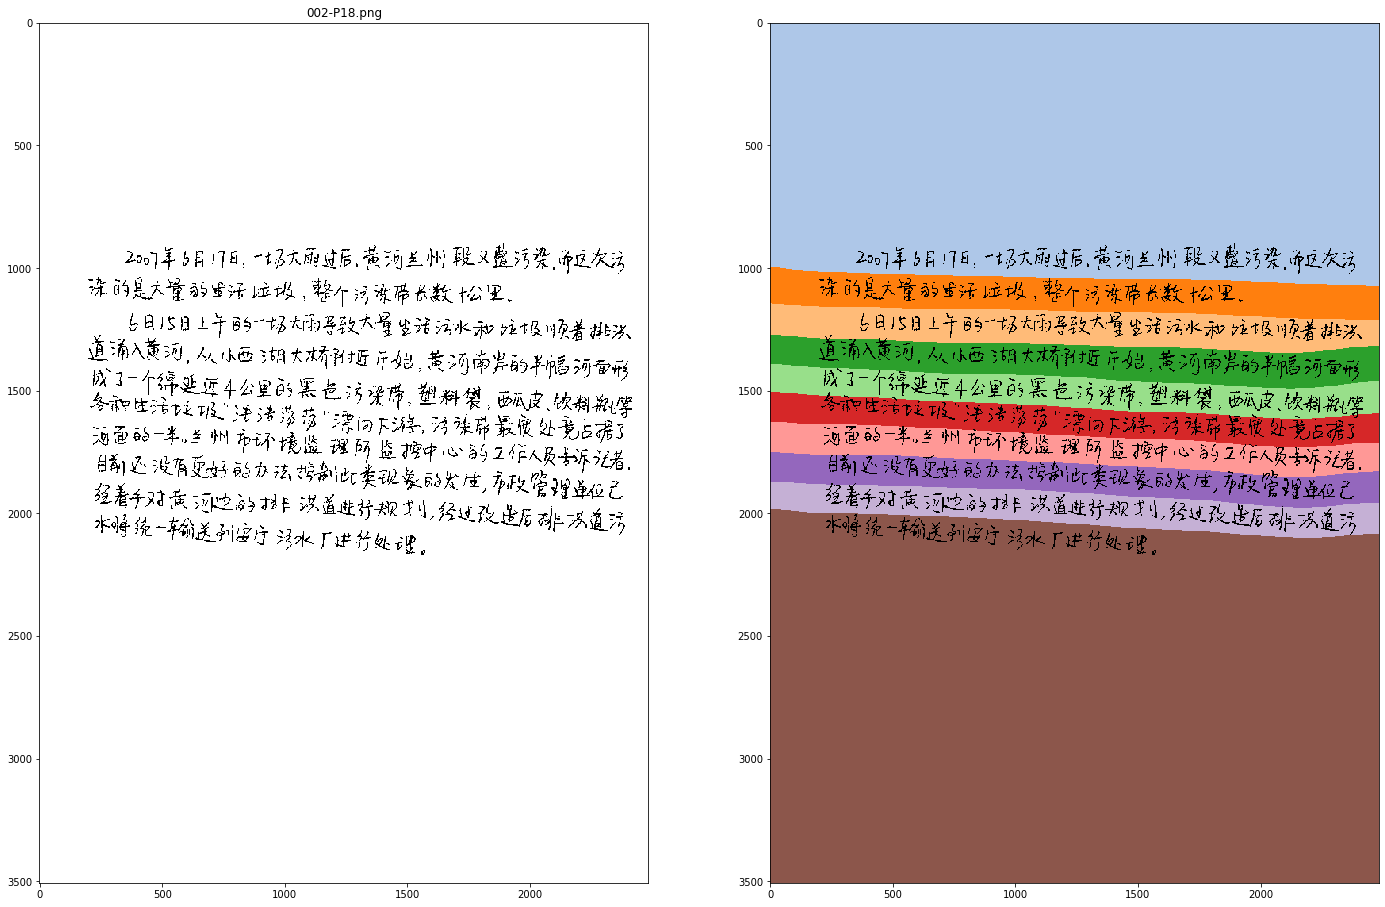

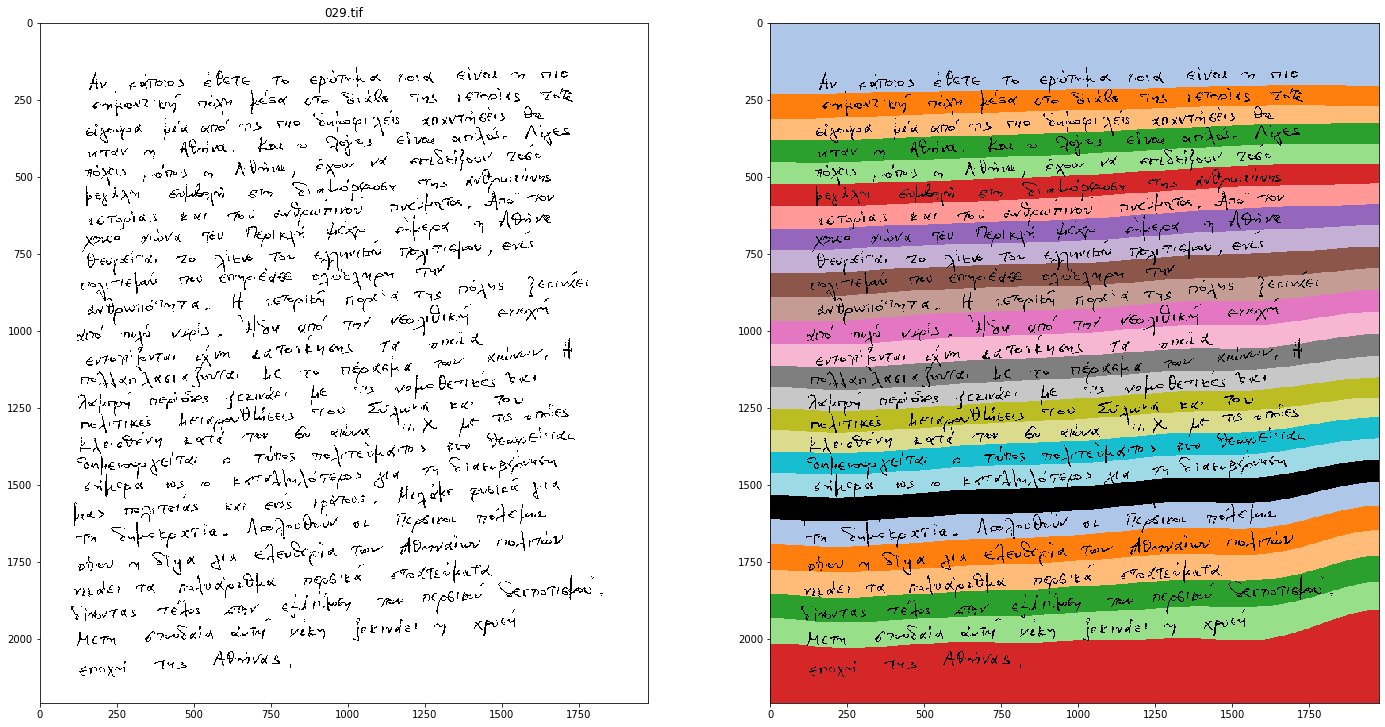

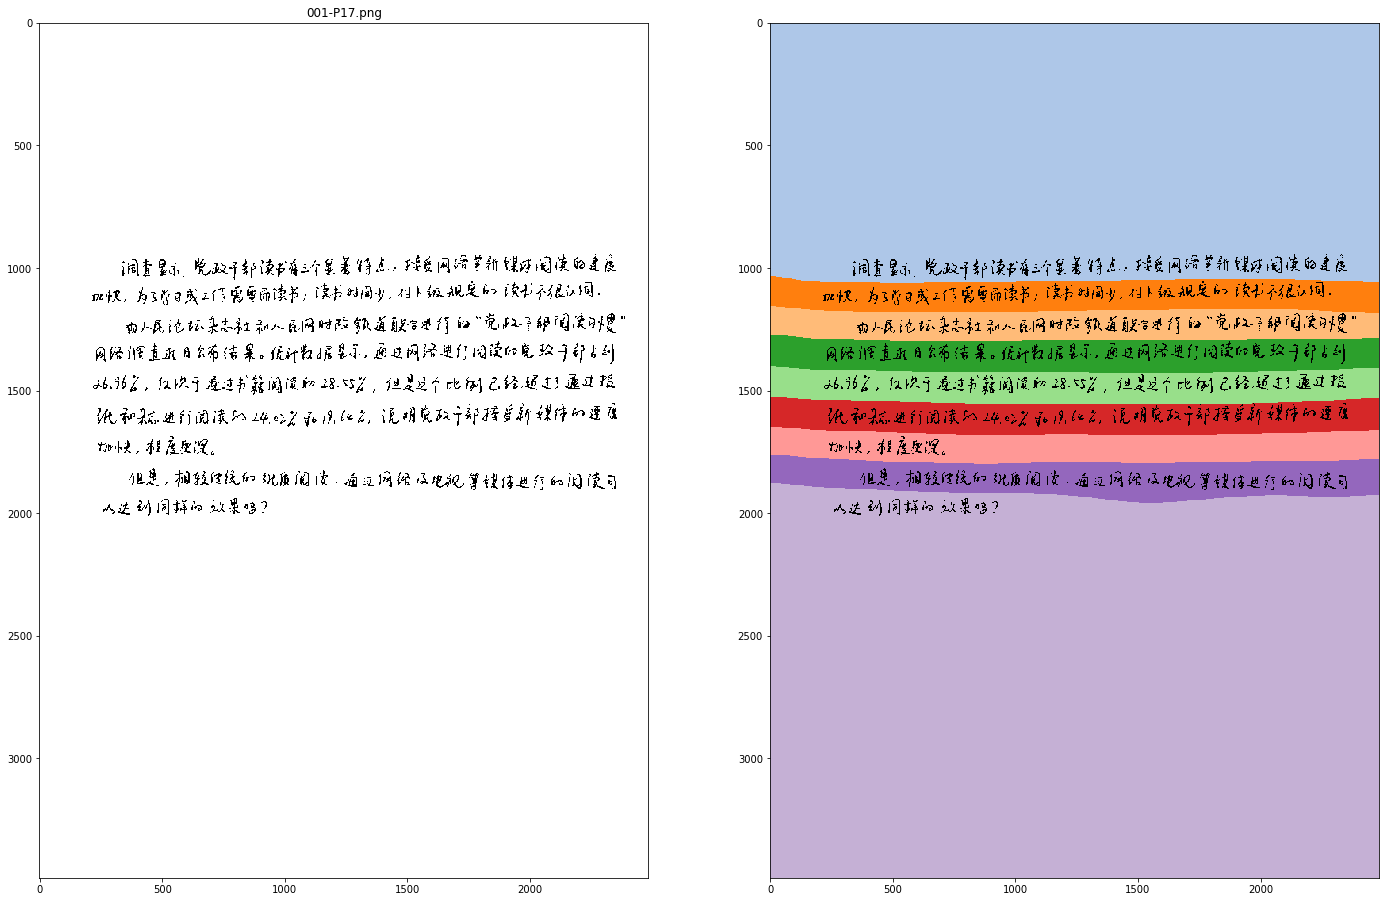

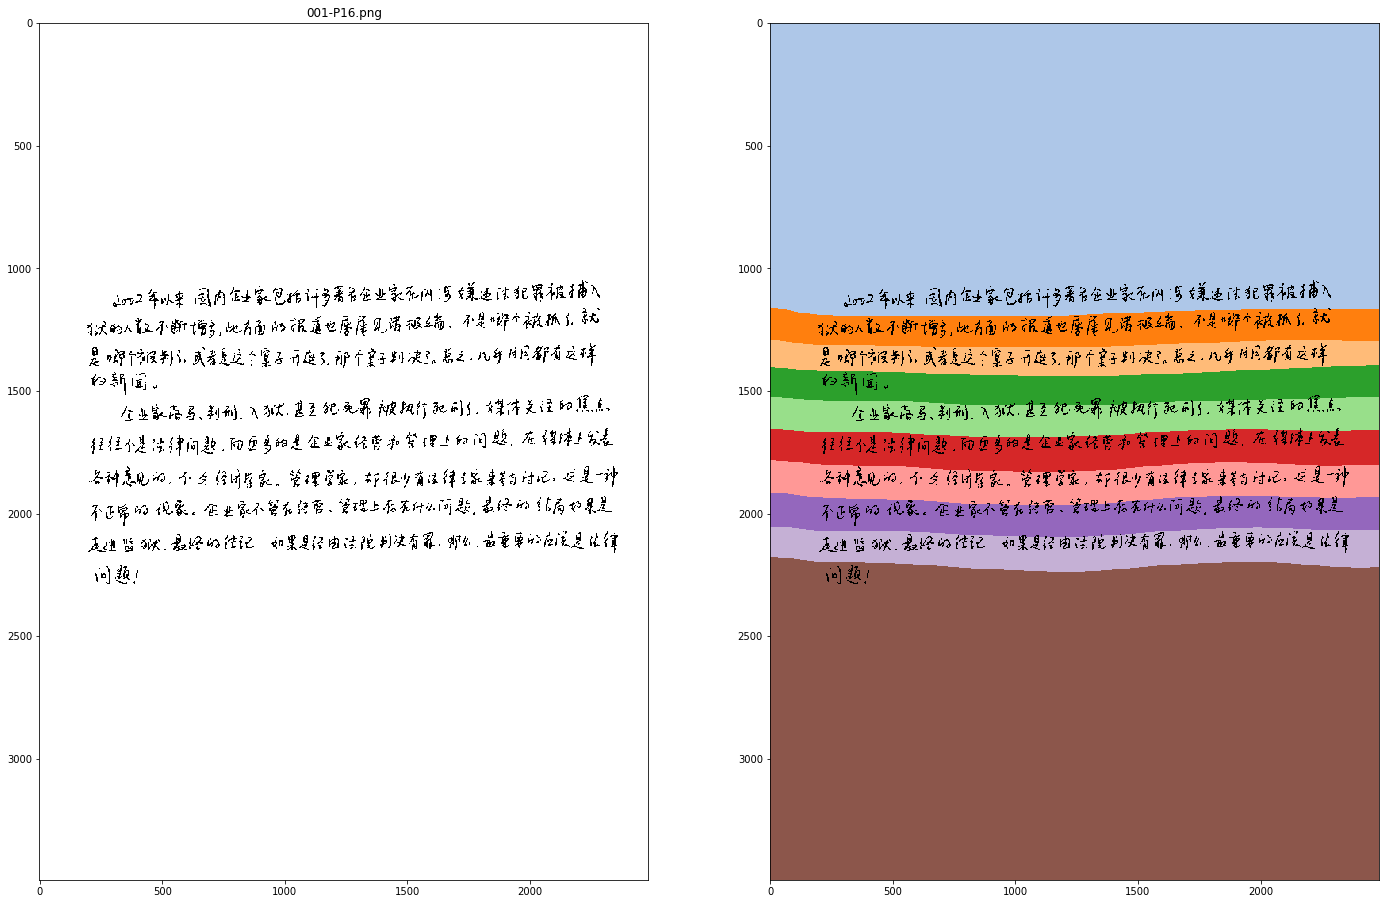

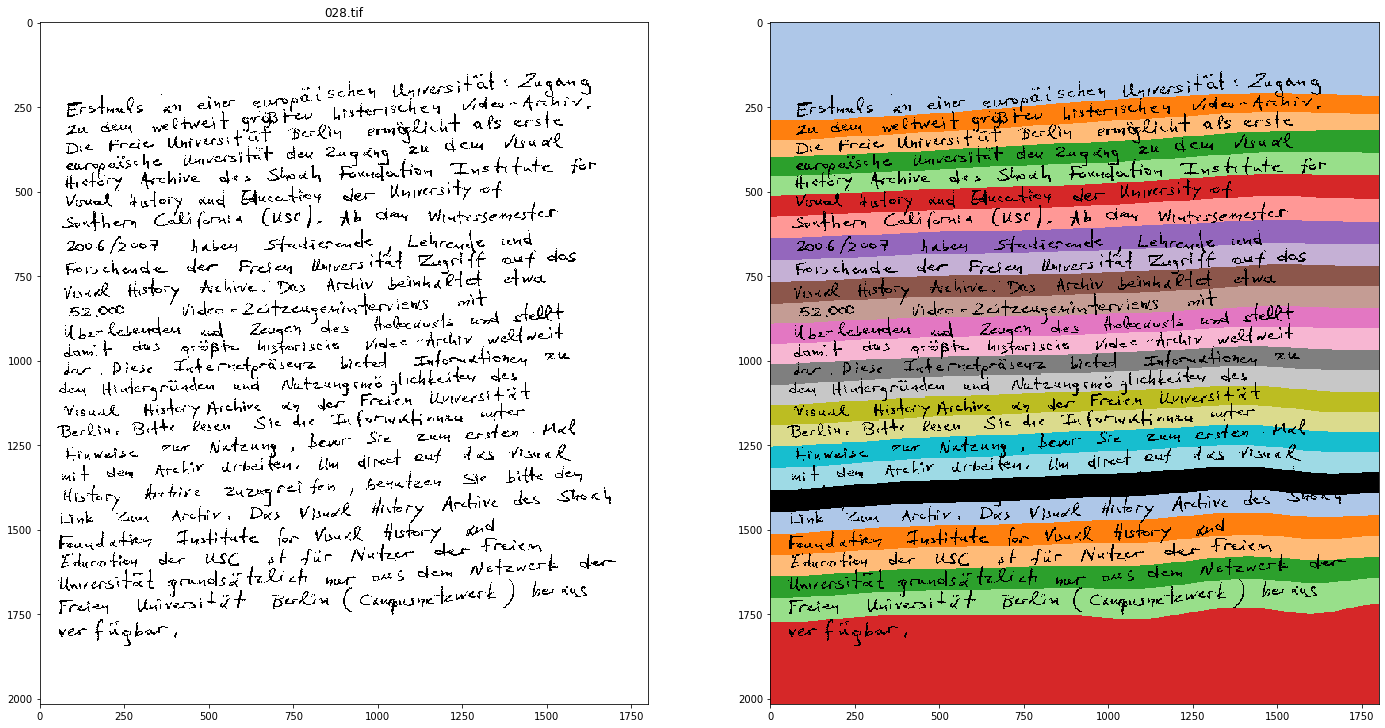

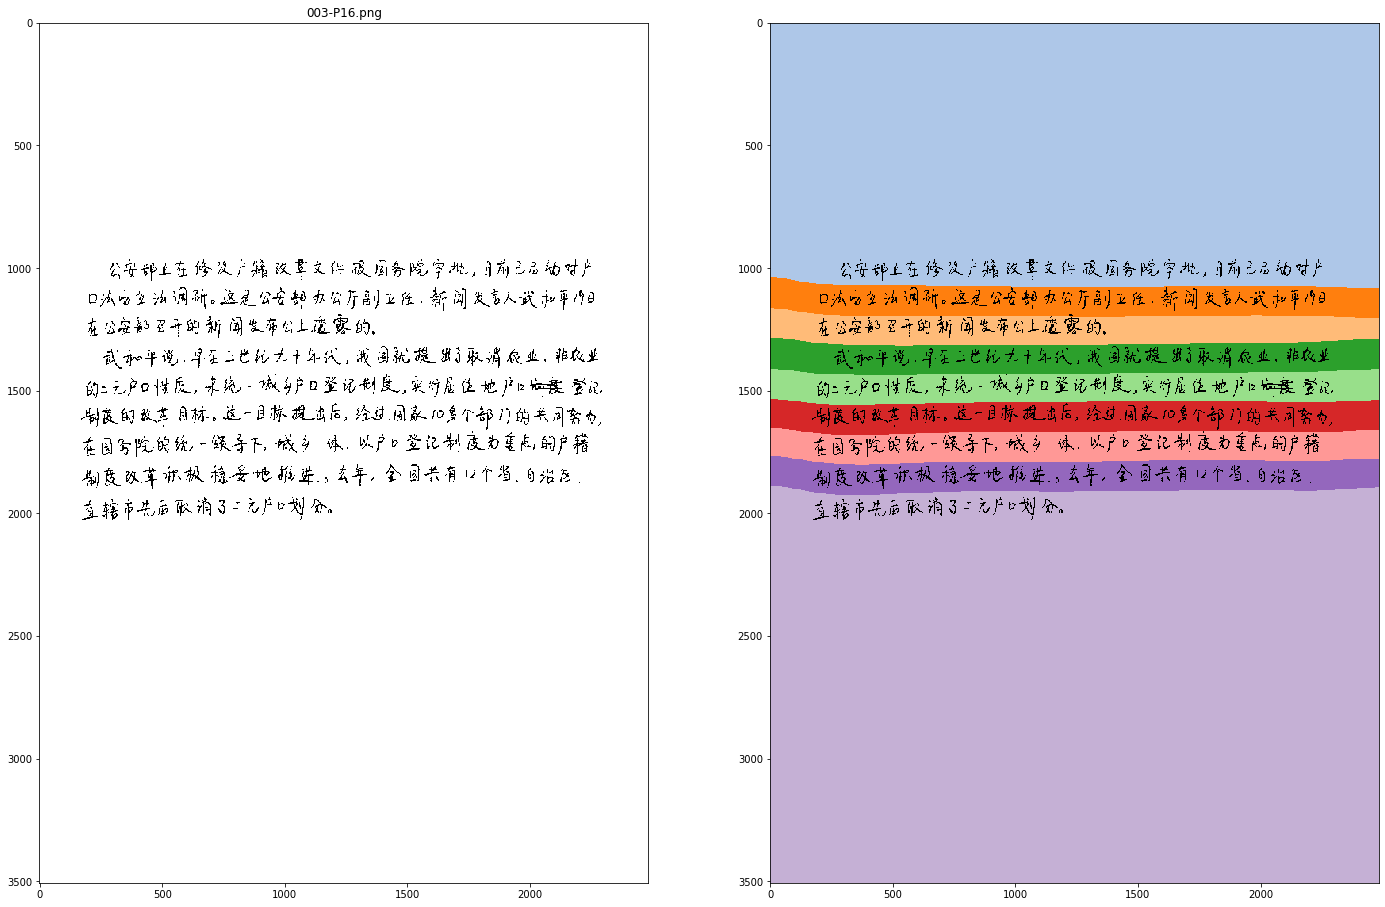

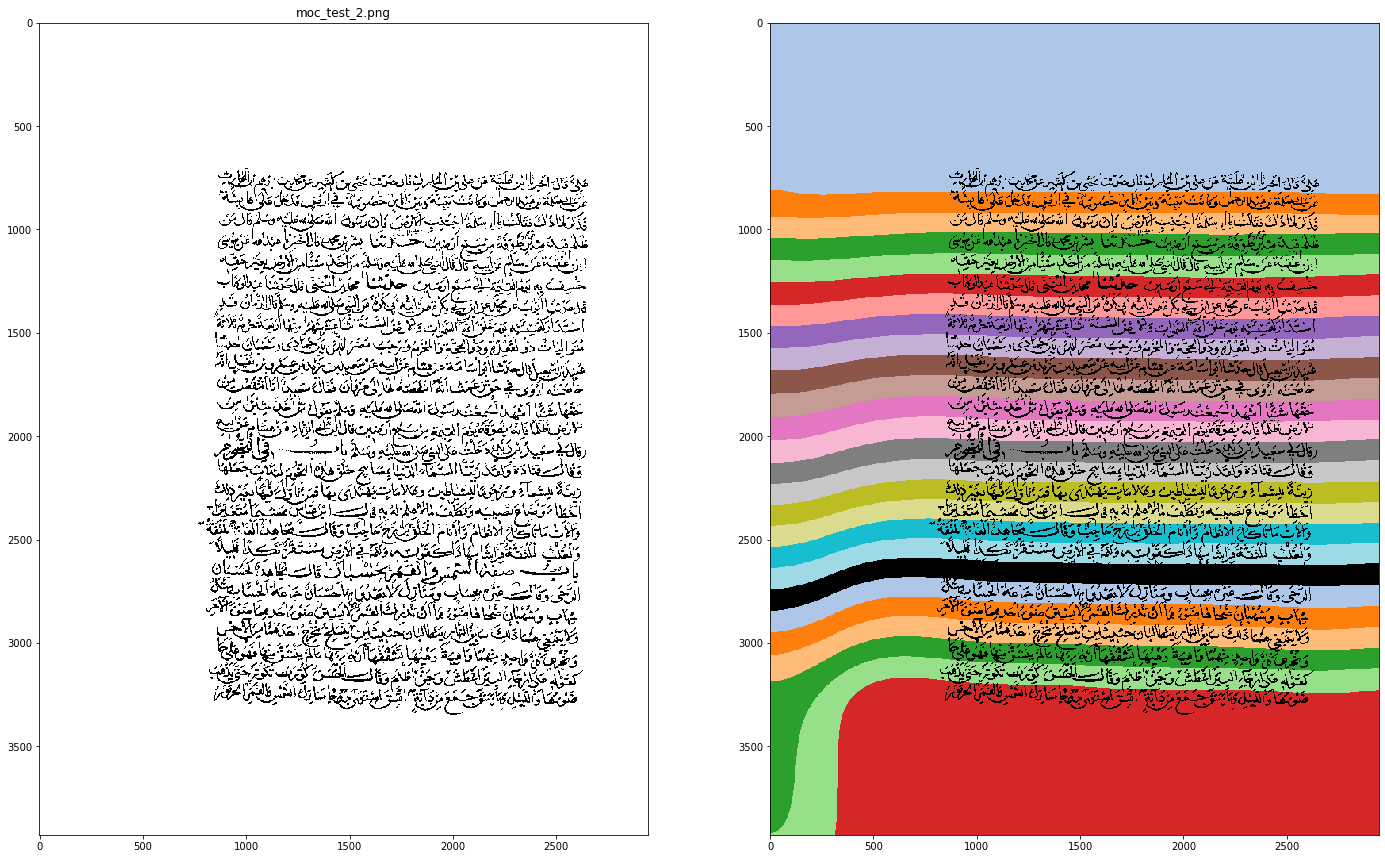

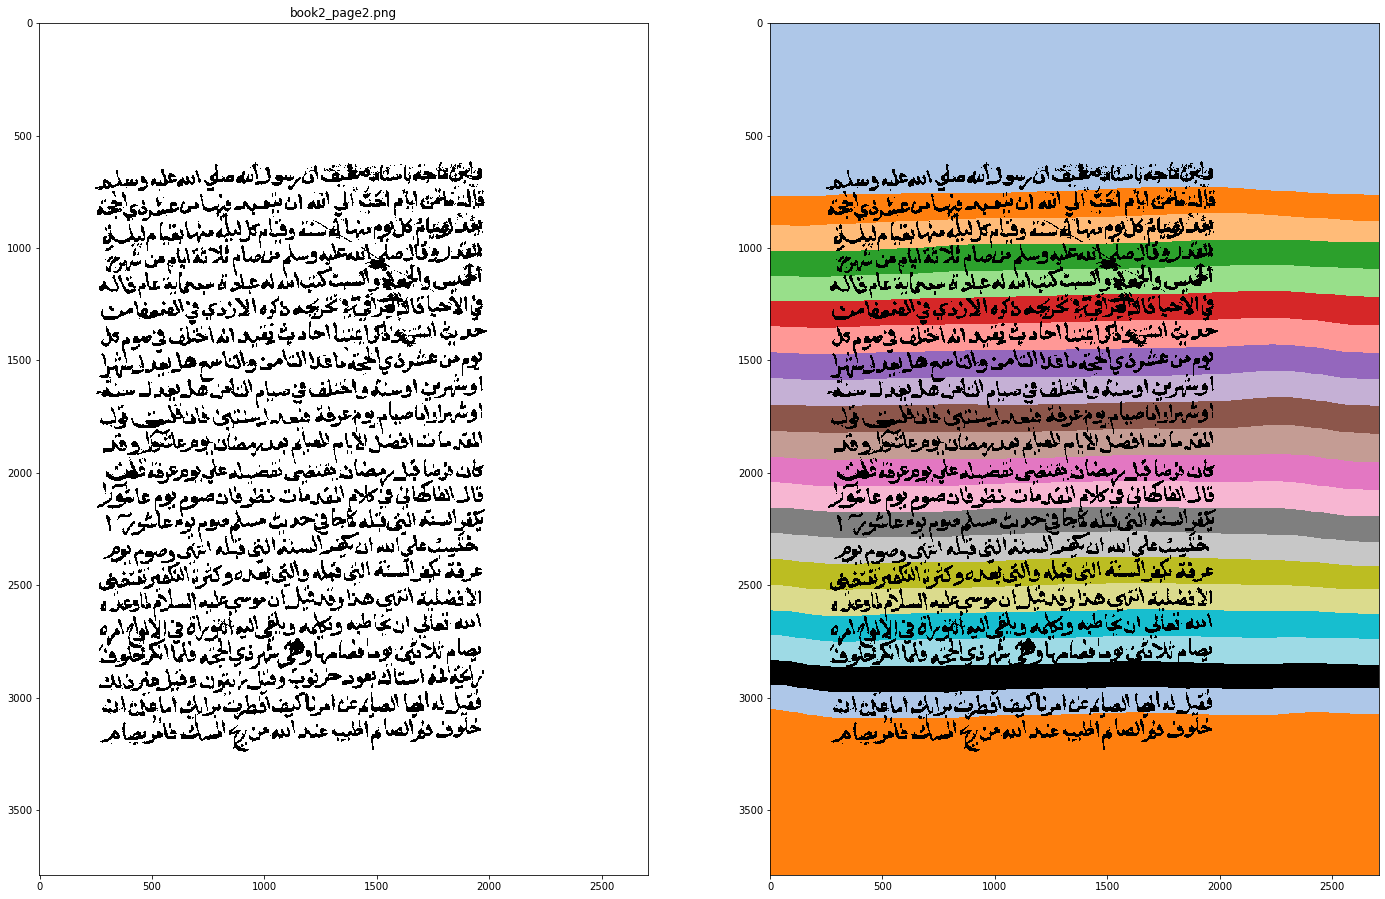

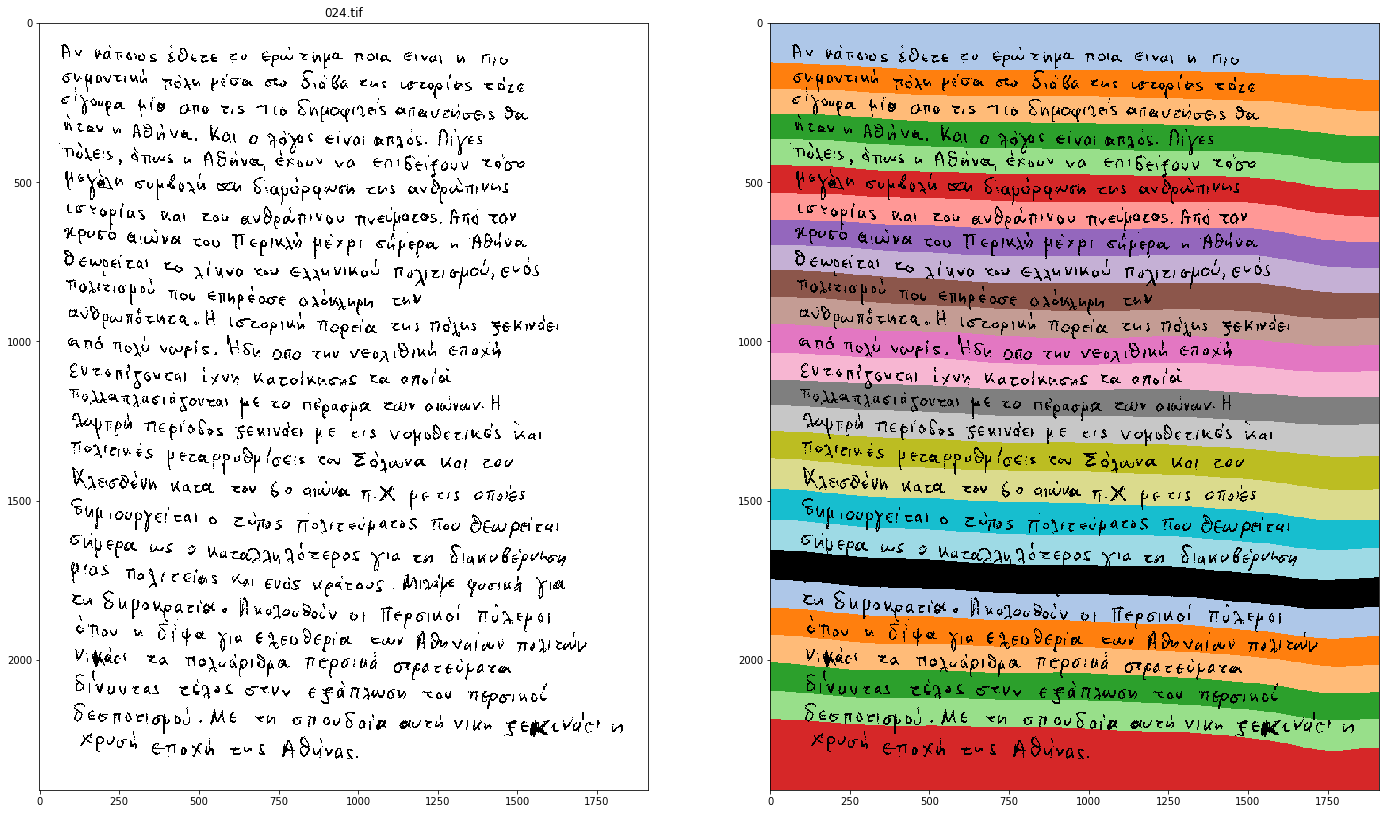

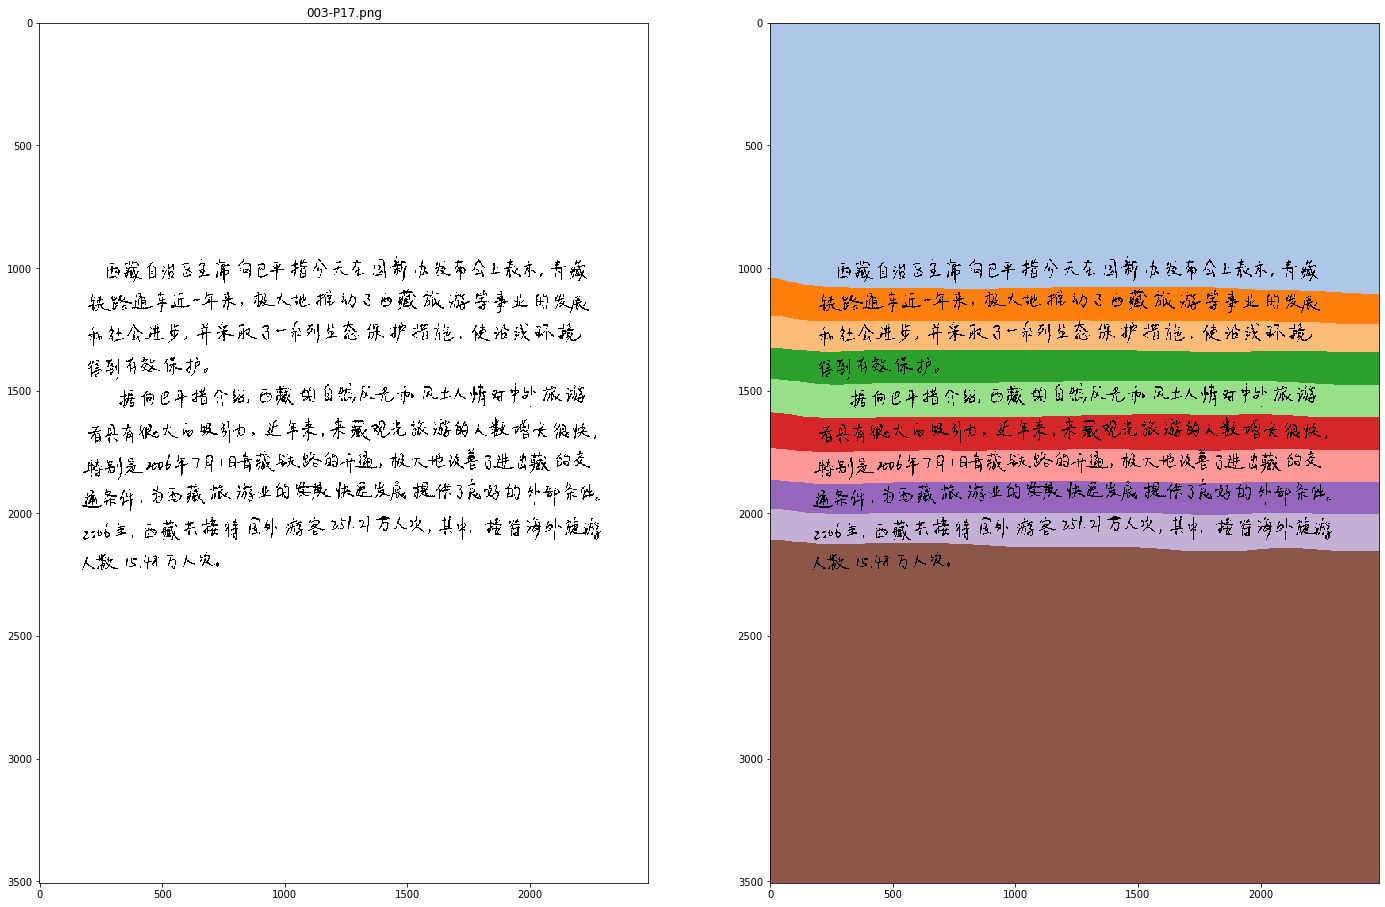

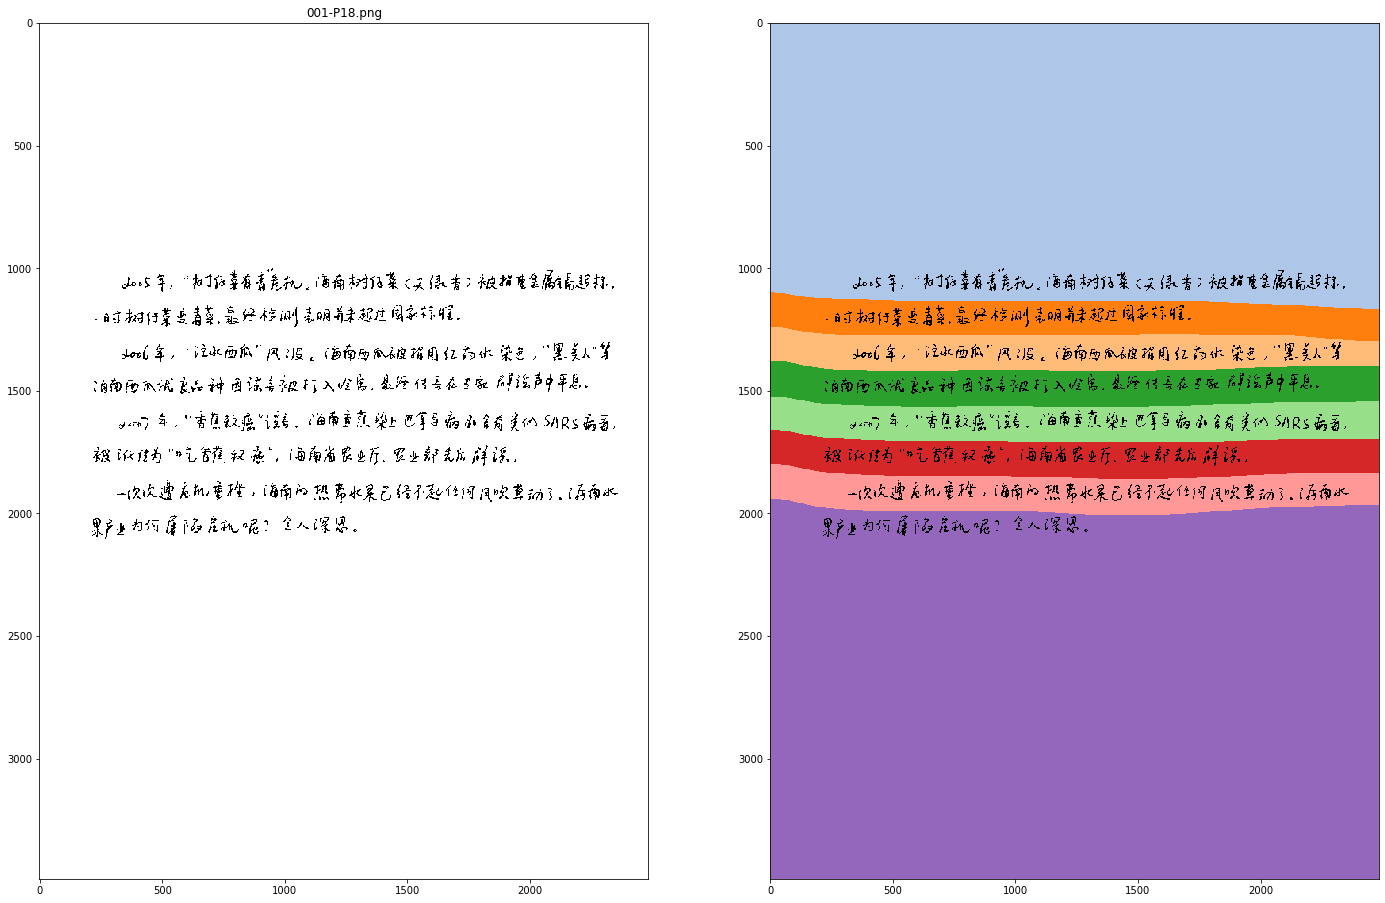

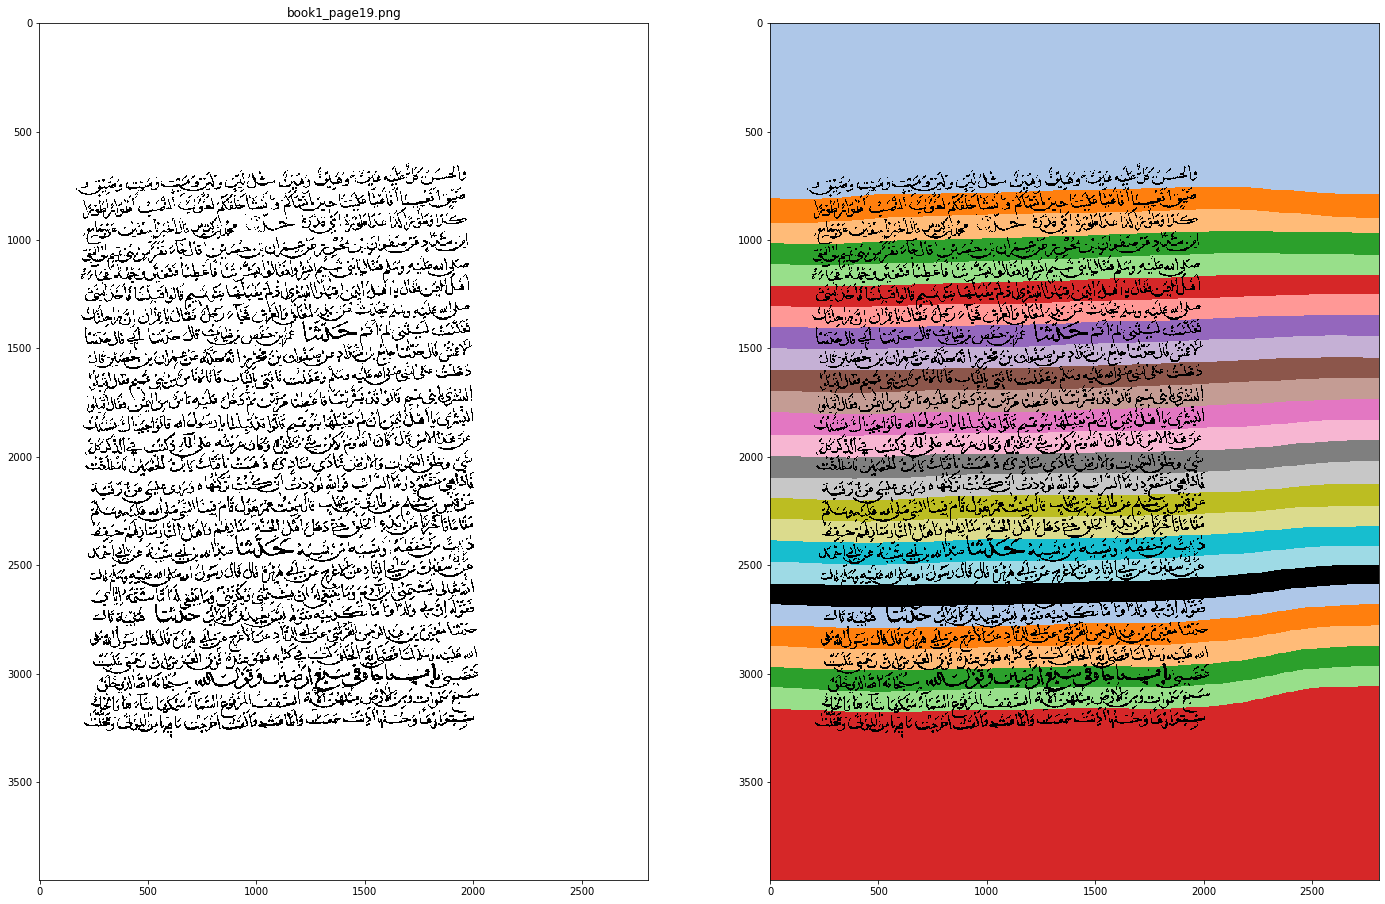

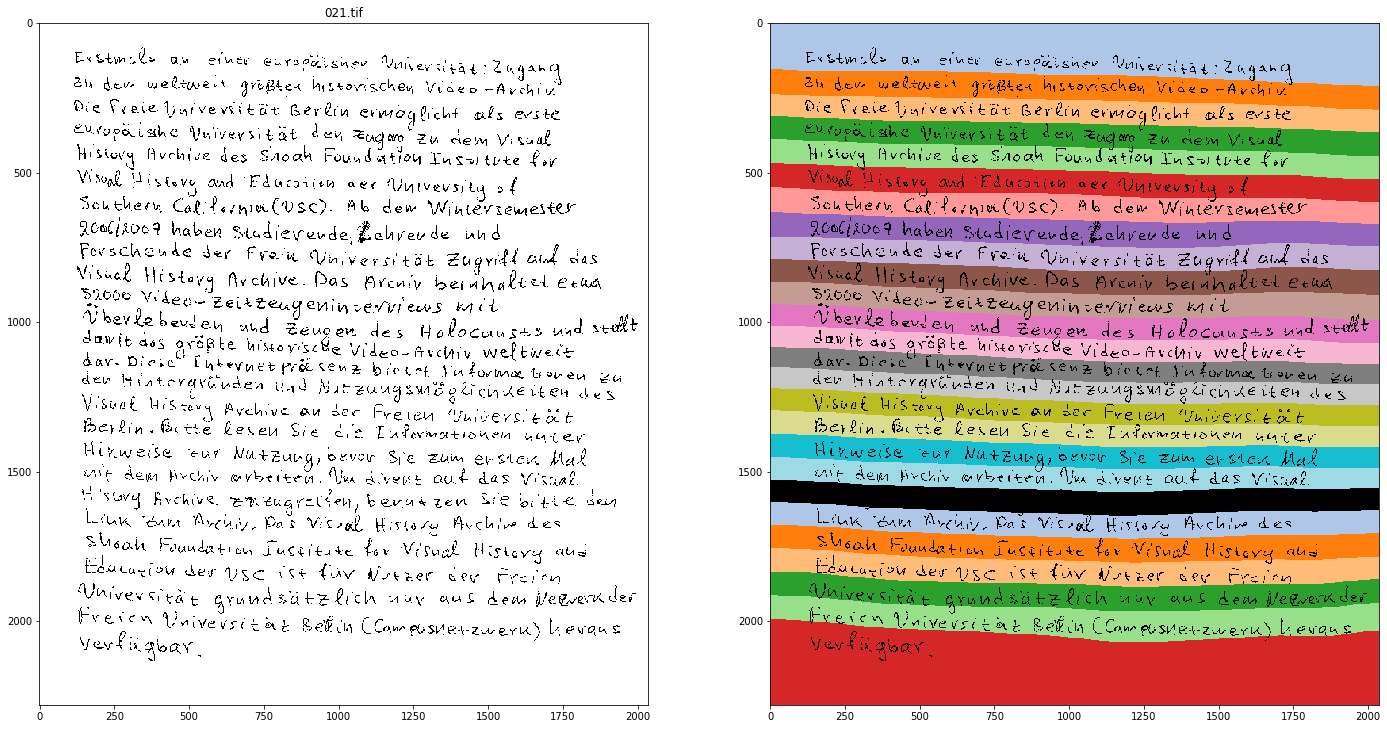

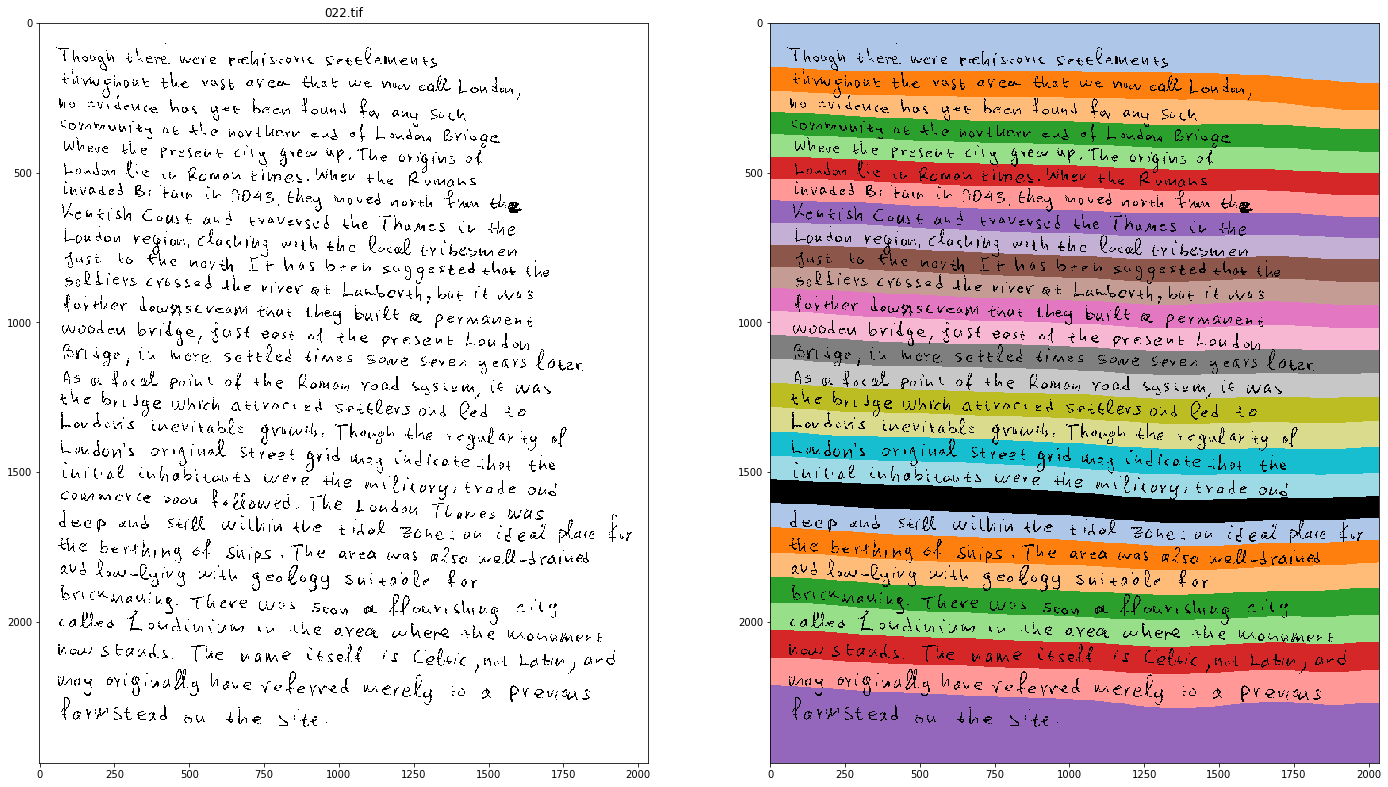

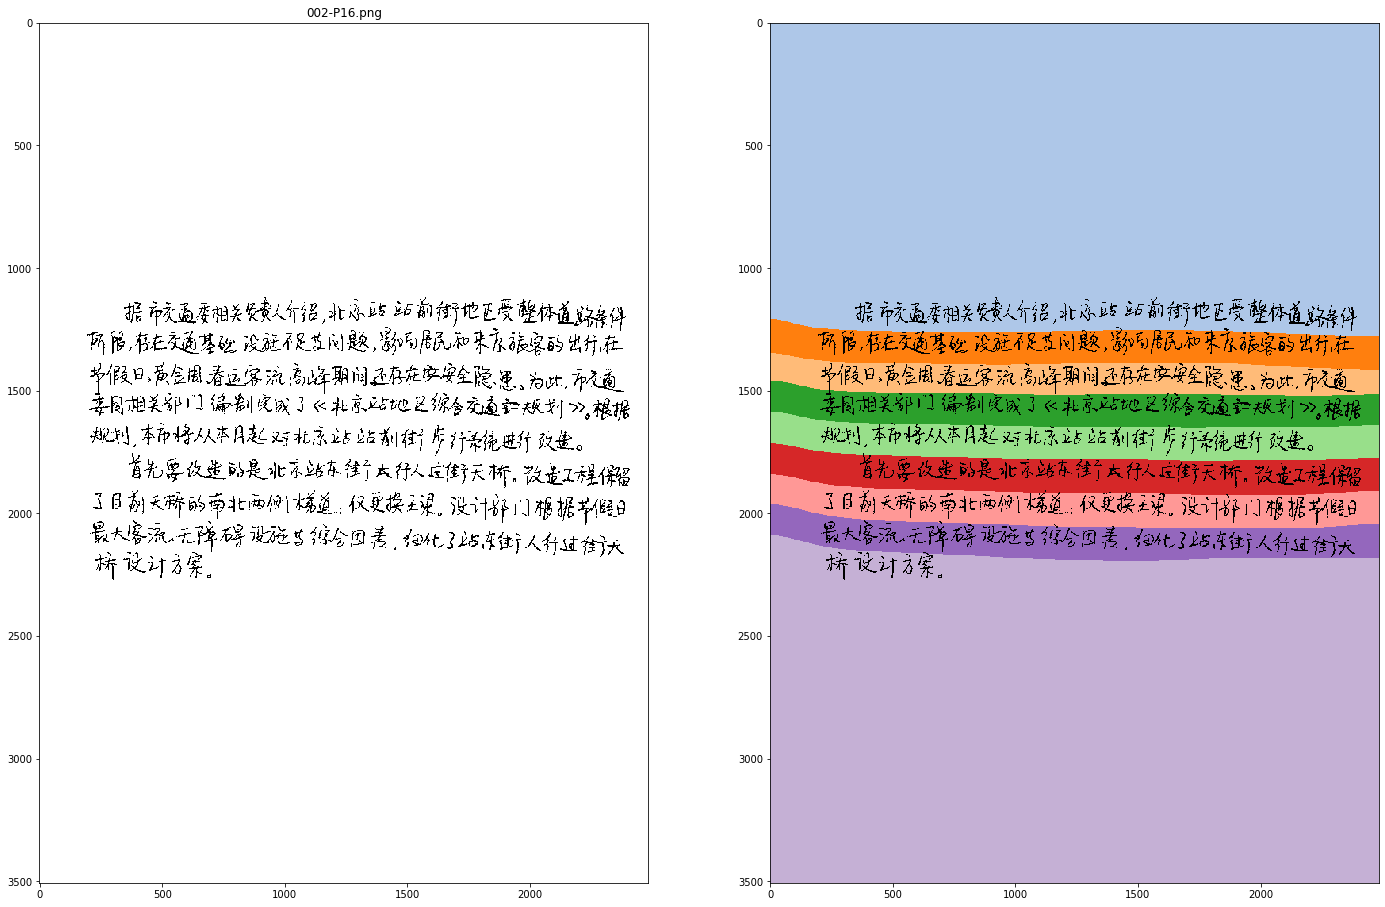

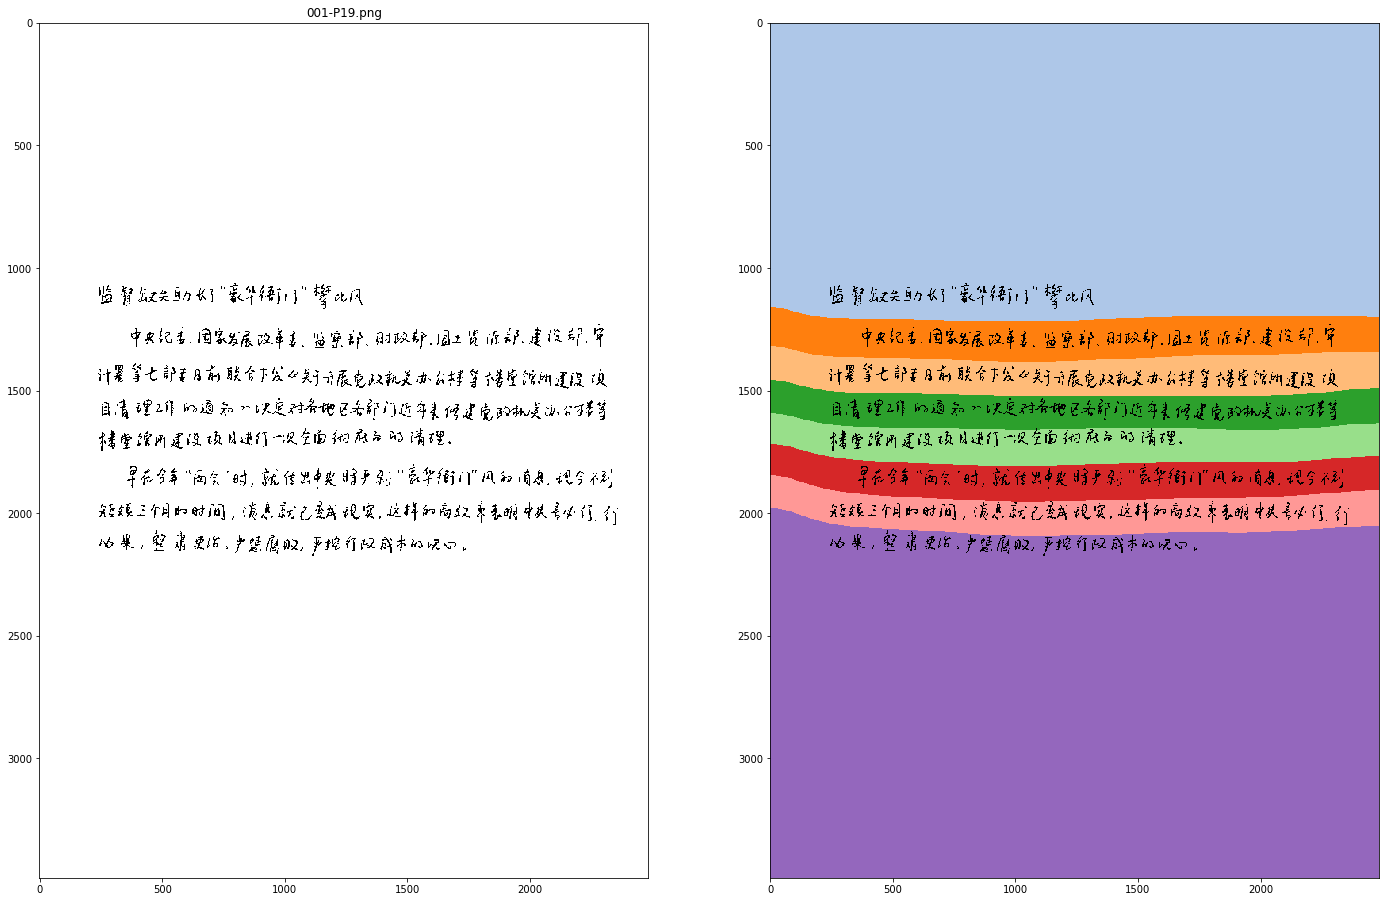

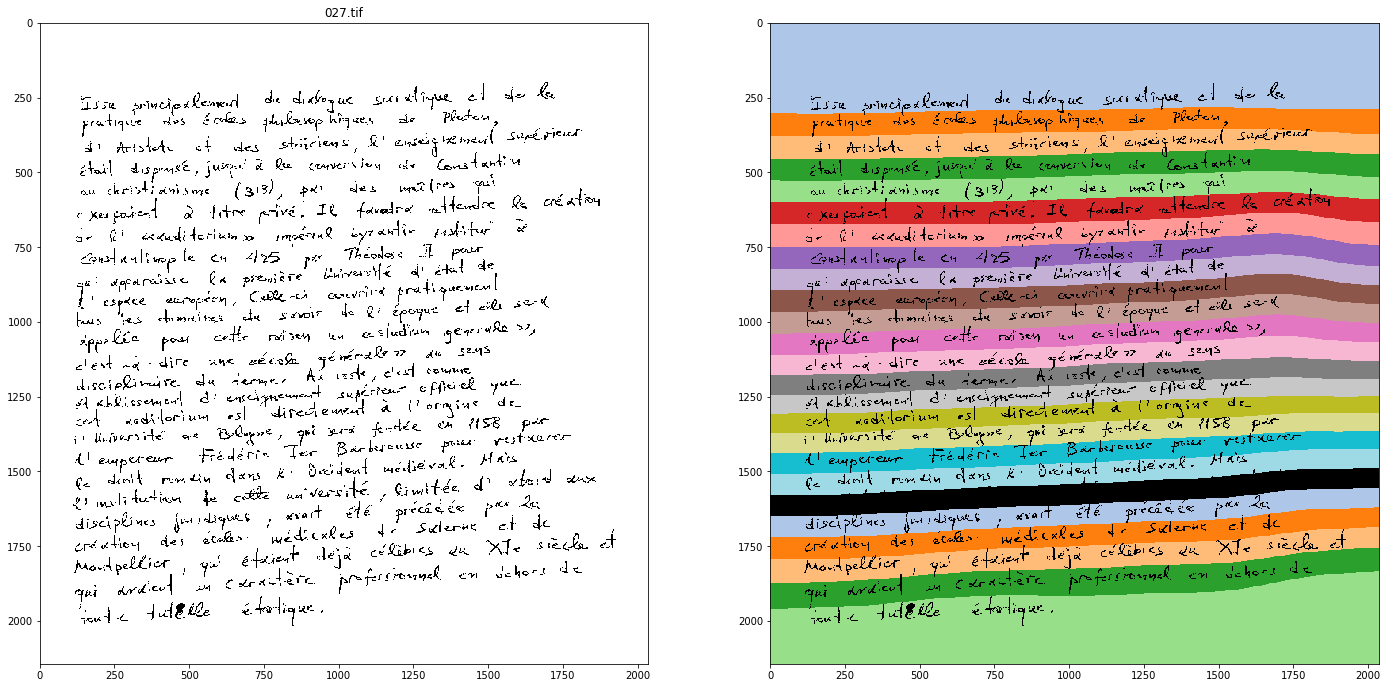

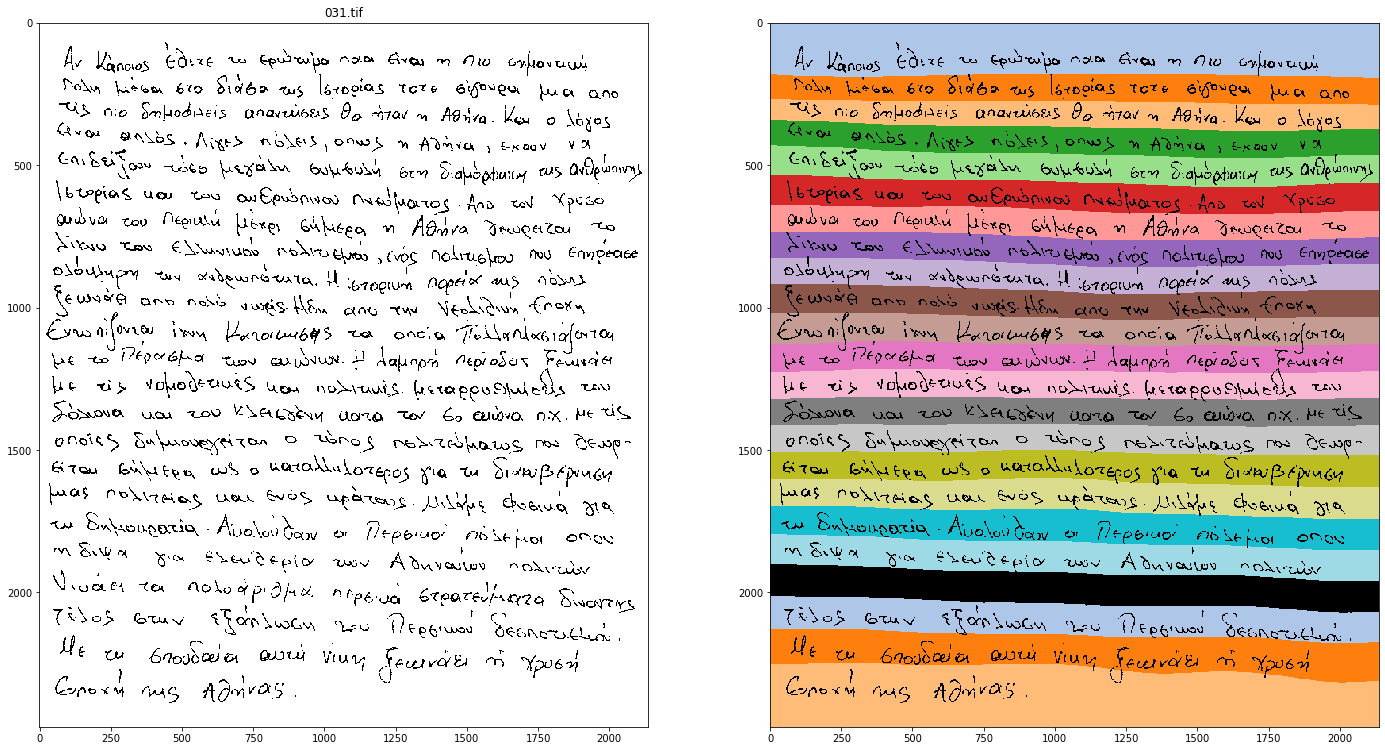

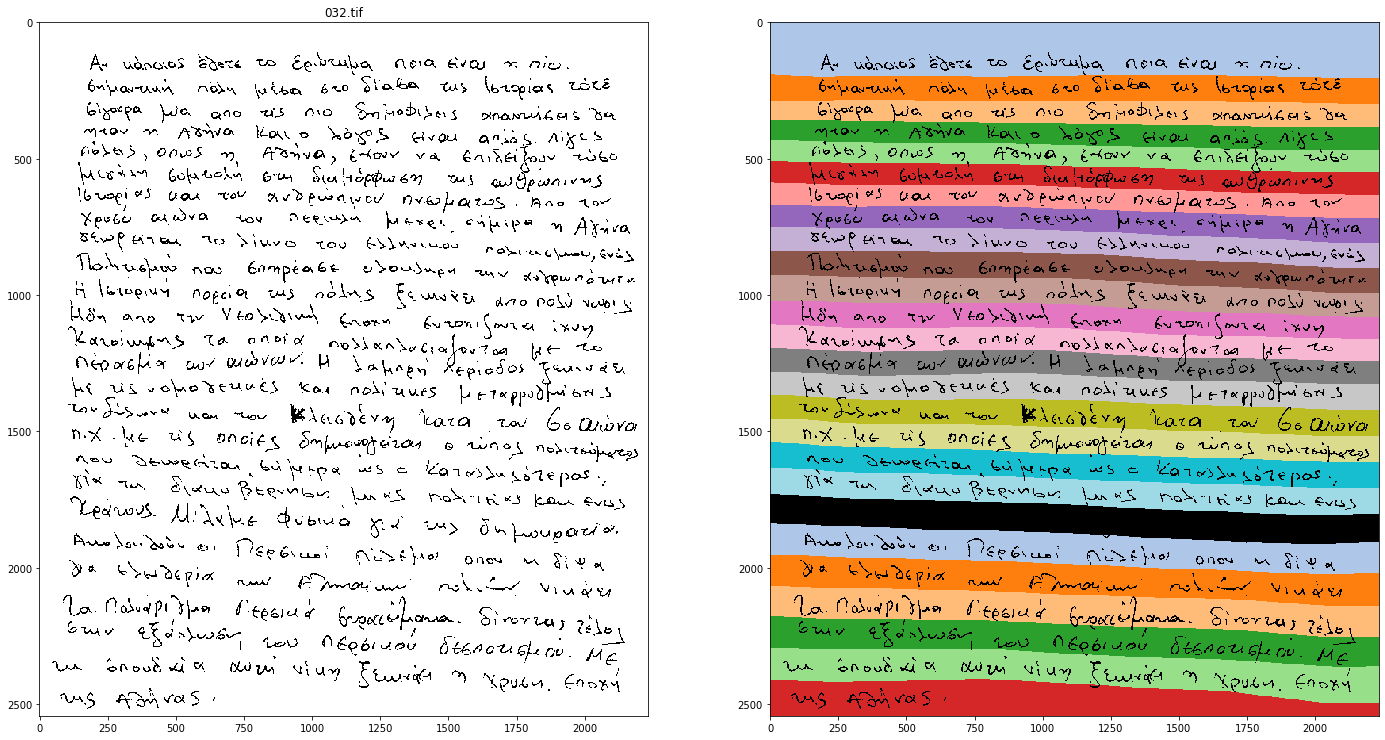

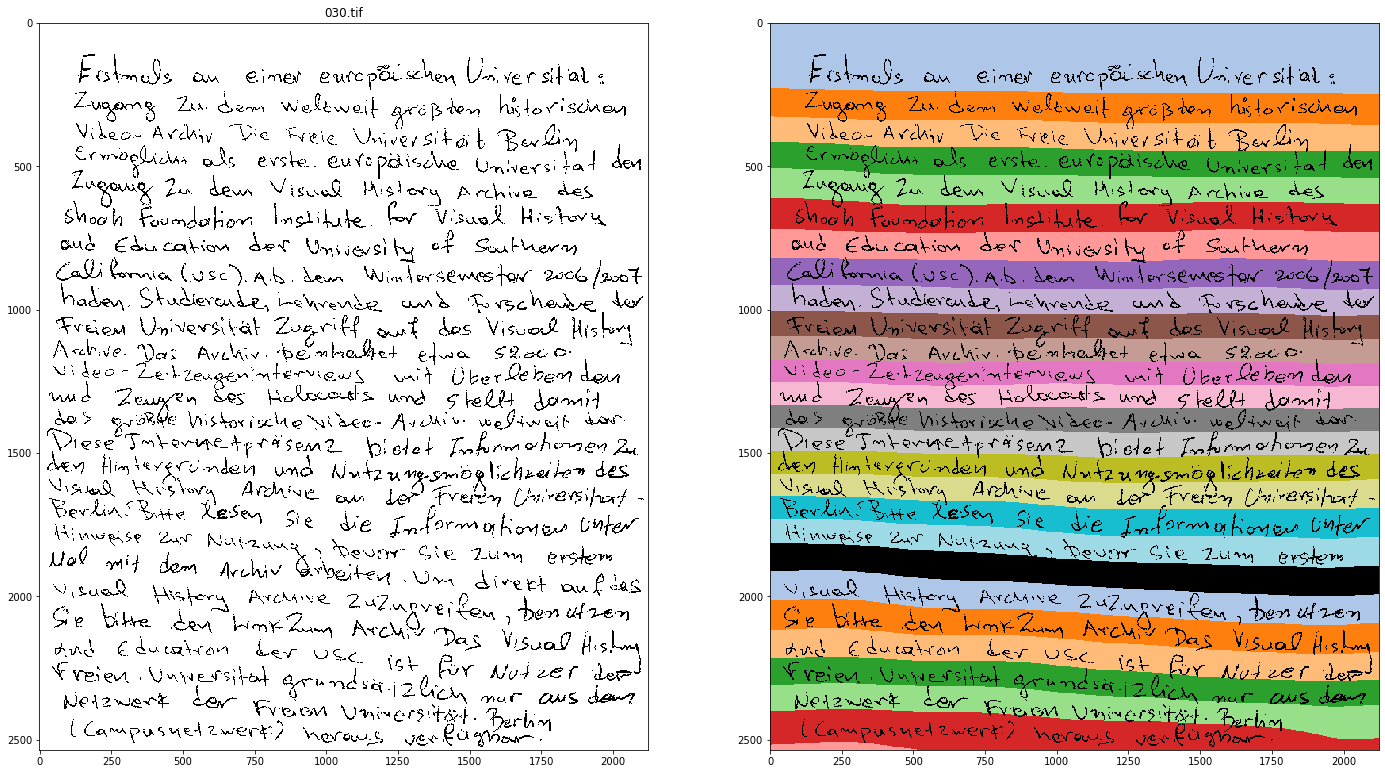

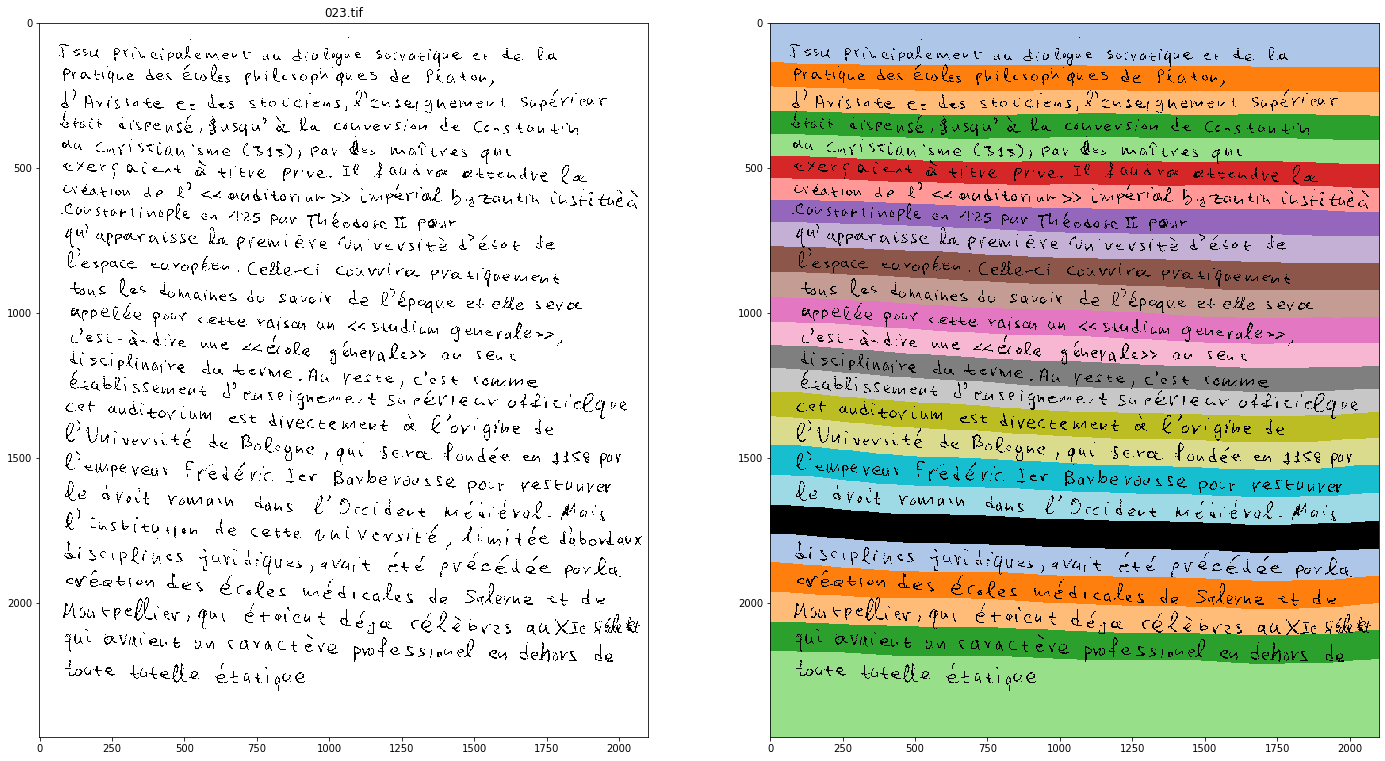

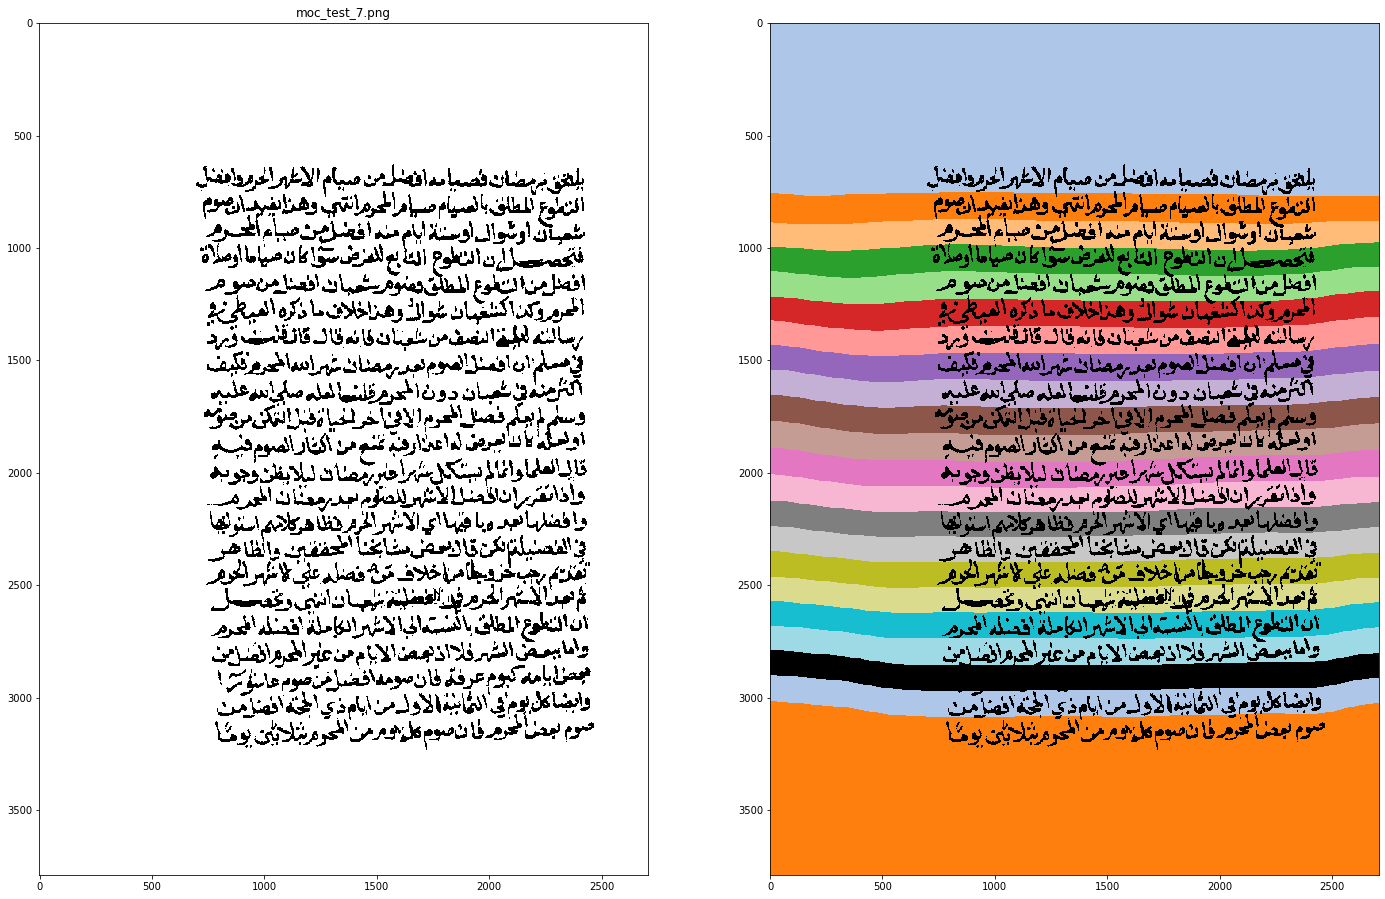

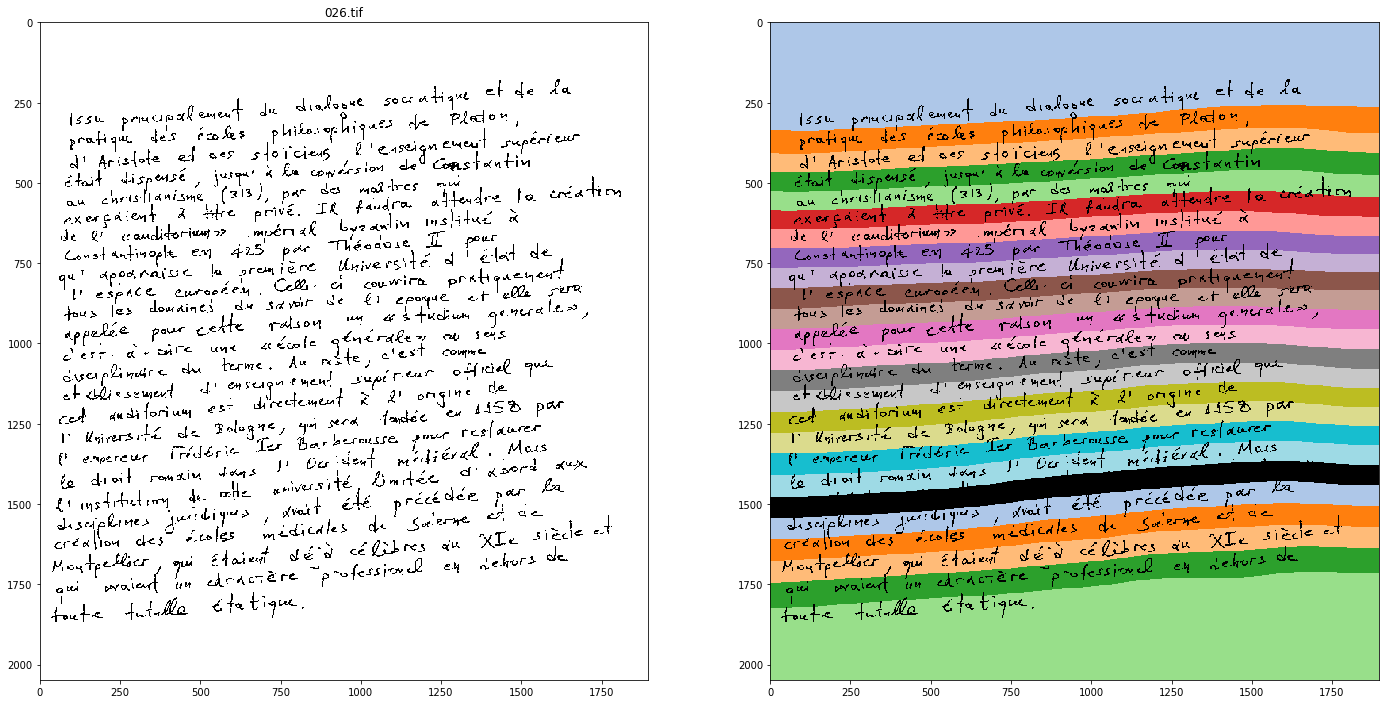

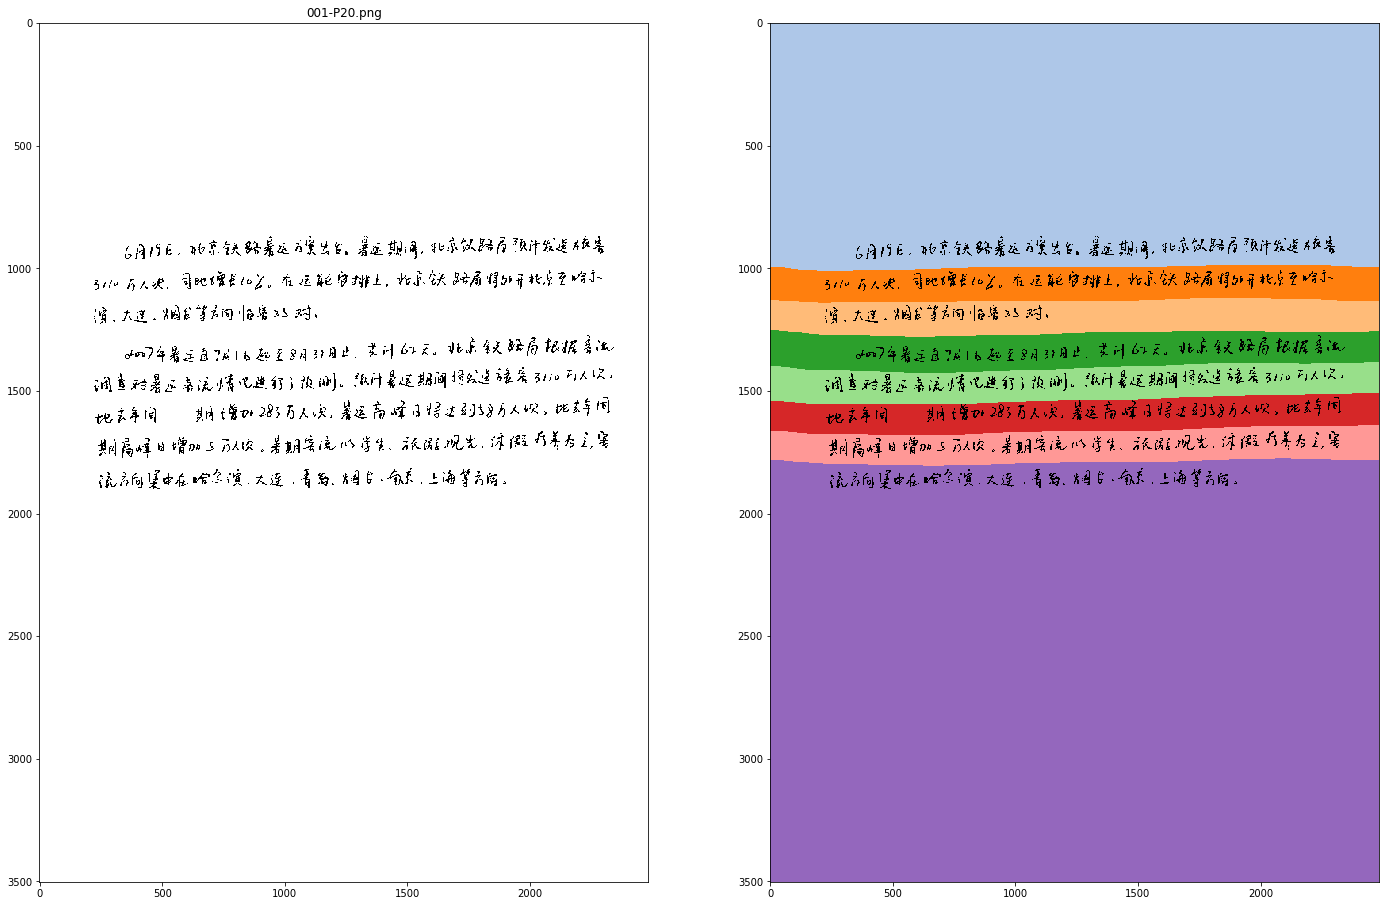

In [27]:
#Plot line segmentation result (some lines are black because we use cmap_tab20 where line_20 = line_0 (black))
for f in os.listdir("samples/"):
    img = cv2.imread("samples/"+f, 0 )
    img = (img>0).astype("uint8")

    #Sacle image to 1088x768
    h = img.shape[0]
    w = img.shape[1]
    cof = 1088/768
    white = np.zeros([int(w*cof),w])
    if h > white.shape[0]:
        img = cv2.resize(img,(768,1088),interpolation=cv2.INTER_NEAREST)
    else:
        white[:h,:w] = img
        pacent = 1088/white.shape[0]    
        img = cv2.resize(white,None,fx=pacent,fy=pacent,interpolation=cv2.INTER_NEAREST)

    x = img
    x = np.expand_dims(x,axis=0)
    x = np.expand_dims(x,axis=-1)
    z = model.predict(x, verbose=1)
    pred = np.round(z[0,...,0])

    #ReSacle image to original Size
    if h > white.shape[0]:
        img = cv2.resize(img,(w,h),interpolation=cv2.INTER_NEAREST)
        pred = cv2.resize(pred,(w,h),interpolation=cv2.INTER_NEAREST)
    else:
        pacent = white.shape[0]/1088    
        img = cv2.resize(img,None,fx=pacent,fy=pacent,interpolation=cv2.INTER_NEAREST)
        pred = cv2.resize(pred,None,fx=pacent,fy=pacent,interpolation=cv2.INTER_NEAREST)
        pred = pred[:h,:w]

        #Put Text on predict result    
        pred = pred*(1-img[:pred.shape[0],:pred.shape[1]])

        pyplot.figure(figsize=(24,20))
        pyplot.axis("off")
        pyplot.subplot(122)   
        pyplot.imshow( pred%20, vmin=0, vmax=19,cmap=newcmp1)
        pyplot.subplot(121)
        pyplot.title(f)
        pyplot.imshow(pred>0,cmap="gray")
        
        
